In [75]:
# all tensorflow api is accessible through this
import tensorflow as tf
# to visualize the resutls
import matplotlib.pyplot as plt
# 70k mnist dataset that comes with the tensorflow container
from tensorflow.examples.tutorials.mnist import input_data

In [76]:
# Data ingestion

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)  

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [77]:
tf.set_random_seed(0)

In [78]:
# 1. Define Variables and Placeholders

X = tf.placeholder(tf.float32, [None, 784]) #the first dimension (None) will index the images
Y_ = tf.placeholder(tf.float32, [None,10])  # placeholder of correct values
x_image = tf.reshape(X, [-1,28,28,1])
pkeep = tf.placeholder(tf.float32)

# Weights 

W1 = tf.Variable(tf.truncated_normal([5, 5, 1, 4],stddev = 0.1))# 784 = 28 * 28
B1 = tf.Variable(tf.zeros([4]))


W2 = tf.Variable(tf.truncated_normal([5, 5, 4, 8], stddev = 0.1))
B2 = tf.Variable(tf.zeros([8]))

W3 = tf.Variable(tf.truncated_normal([4, 4, 8, 12], stddev = 0.1))
B3 = tf.Variable(tf.zeros([12]))

W_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 12, 200], stddev=0.1))# fully connected wt 
b_fc1 = tf.Variable(tf.zeros([200])) # fully connected bias
                    
W_readout = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
B_readout = tf.Variable(tf.zeros([10]))

In [98]:
# Learning rate placeholer

global_step = tf.Variable(0, trainable=False)

starter_learning_rate = 0.5

lr = tf.train.exponential_decay(starter_learning_rate, global_step,100, 1.0, staircase=True)


# placeholder for probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
pkeep = tf.placeholder(tf.float32)

In [99]:
# Define the model

Y_1 = tf.nn.relu(tf.nn.conv2d(x_image, W1, strides=[1, 1, 1, 1], padding="SAME") + B1)
print Y_1

Y_2 = tf.nn.relu(tf.nn.conv2d(Y_1, W2, strides=[1, 2, 2, 1], padding="SAME") + B2)
print Y_1
Y_3 = tf.nn.relu(tf.nn.conv2d(Y_2, W3, strides=[1, 2, 2, 1], padding="SAME") + B3)
print Y_3

#Y = tf.nn.softmax(Y_3)
Y = tf.reshape(Y_3, [-1,7*7*12])  # Reshape to fit fully connected layer
print Y
h_fc1 = tf.nn.relu(tf.matmul(Y,W_fc1 ) + b_fc1)

# Readout layer

Y_logits = tf.matmul(h_fc1, W_readout) + B_readout
Y_readout = tf.nn.softmax(Y_logits)

print Y_readout



Tensor("Relu_30:0", shape=(?, 28, 28, 4), dtype=float32)
Tensor("Relu_30:0", shape=(?, 28, 28, 4), dtype=float32)
Tensor("Relu_32:0", shape=(?, 7, 7, 12), dtype=float32)
Tensor("Reshape_29:0", shape=(?, 588), dtype=float32)
Tensor("Softmax_5:0", shape=(?, 10), dtype=float32)


In [80]:
# Define the loss function

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(Y_logits, Y_)) 

In [87]:
#  Define the accuracy 
# tf.argmax is function which gives you the index of the highest entry in a tensor along some axis.
# For example, tf.argmax(y,1) is the label our model thinks is most likely for each input, 
#while tf.argmax(y_,1) is the true label. 

#is_correct = tf.equal(tf.argmax(Ylogits,1), tf.argmax(Y_,1))

is_correct = tf.equal(tf.argmax(Y_readout,1), tf.argmax(Y_,1))


accuracy = tf.reduce_mean(tf.cast(is_correct,tf.float32))

In [93]:
# Define an optimizer

optimizer = tf.train.GradientDescentOptimizer(0.5)
#optimizer = tf.train.GradientDescentOptimizer(0.5)
#optimizer = tf.train.AdamOptimizer(0.005)
train_step = optimizer.minimize(cross_entropy)

In [94]:
# Define and run the session, initialising all the variables
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [95]:
def training_step(i, update_test_data, update_train_data):
    print "\r", i,
    #Reading the batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, pkeep:0.5})
    
    ####### evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    #rray containing the test, train accuracy and cross entrpopy values
    train_a = []
    train_c = []
    test_a =  []
    test_c =  []
    
    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y, pkeep :0.5})
        train_a.append(a)
        train_c.append(c)
        
    if update_test_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels, pkeep :1.0})
        test_a.append(a)
        test_c.append(c)
    
    return (train_a, train_c, test_a, test_c)


In [96]:
# 6. Train and test the model, store the accuracy and loss per iteration

train_a = []
train_c = []
test_a = []
test_c = []

training_iter = 10000
epoch_size = 100

for i in range(training_iter):
    test = False
    if i % epoch_size == 0:  # Creating bins of 100
        test = True
        
    a, c, ta, tc = training_step(i, test, test)
    train_a += a
    train_c += c
    test_a += ta
    test_c += tc

9999


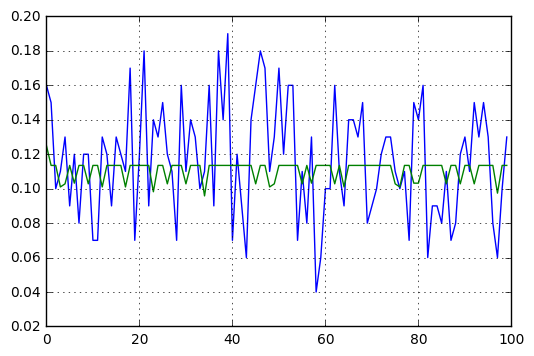

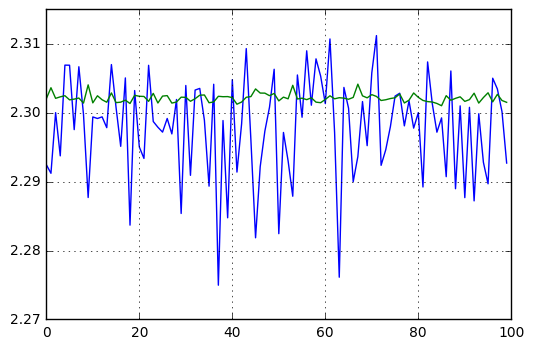

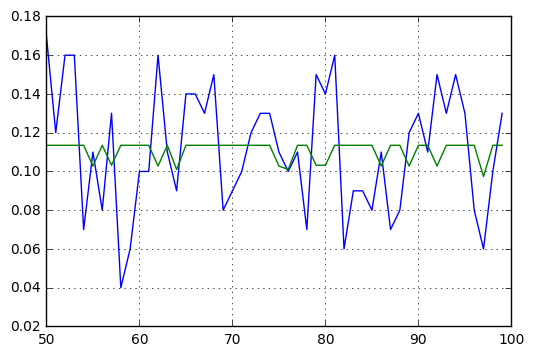

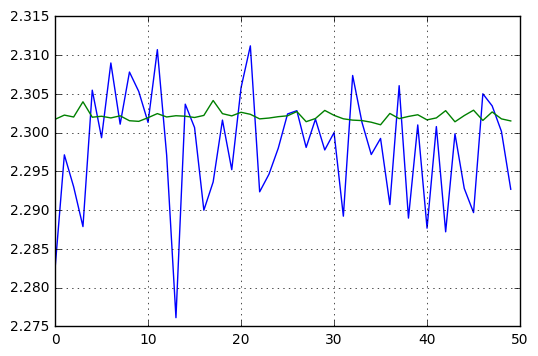

In [97]:
# 7. Plot and visualise the accuracy and loss

# accuracy training vs testing dataset

plt.plot(train_a)
plt.plot(test_a)
plt.grid(True)
plt.show()

# Loss Training vs test data
plt.plot(train_c)
plt.plot(test_c)
plt.grid(True)
plt.show()


# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,training_iter/epoch_size)
plt.plot(x_range, train_a[zoom_point:])
plt.plot(x_range, test_a[zoom_point:])
plt.grid(True)
plt.show()

plt.plot(train_c[zoom_point:])
plt.plot(test_c[zoom_point:])
plt.grid(True)
plt.show()